## Random Forest - viscosity - 2bins - 72/28

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

In [2]:
df = pd.read_csv(f"../Viscosity_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Chemicals                                    100 non-null    object 
 1   SMILES                                       100 non-null    object 
 2   Temperature (kelvin)                         100 non-null    float64
 3   Dynamic Viscosity (cp)                       100 non-null    float64
 4   Classification (based on dynamic viscosity)  100 non-null    object 
 5   viscosity_2bins_5050                         100 non-null    int64  
 6   viscosity_7228                               100 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 5.6+ KB


In [3]:
def smiles_to_fingerprint(smiles) -> np.ndarray:
    """
    Convert a SMILES string to a molecular fingerprint using RDKit.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # generate Morgan fingerprint
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=20, fpSize=512)
    fingerprint = mfpgen.GetFingerprint(mol)

    return np.array(fingerprint)

In [4]:
df["mp_bin"] = df["SMILES"].apply(smiles_to_fingerprint)
df["mp_bin"]

0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
2     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                            ...                        
95    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
96    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
97    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
98    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
99    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: mp_bin, Length: 100, dtype: object

In [15]:
def prepare_dataset_classification(
    df,
    target = "viscosity_7228",
    representation = "mp_bin",
    random_state=42,
    train_size=80
):
    df_train, df_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )
    print(len(df_train), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return list(X_train), y_train, list(X_test), y_test

In [16]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, random_state=42):
    clf = RandomForestClassifier(
        n_estimators=200, 
        random_state=random_state,
        verbose=True
    )
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [17]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 40

In [18]:
train_size = 40
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [19]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
40 60
random_state = 42
Accuracy: 0.7333333333333333
F1 macro: 0.4771241830065359
F1 micro: 0.7333333333333333
F1 weighted: 0.6357298474945534
Kappa: 0.08221797323135738
-------------Iteration 2/10
40 60
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7333333333333333
F1 macro: 0.4771241830065359
F1 micro: 0.7333333333333333
F1 weighted: 0.6357298474945534
Kappa: 0.08221797323135738
-------------Iteration 3/10
40 60
random_state = 44
Accuracy: 0.7666666666666667
F1 macro: 0.6103896103896104
F1 micro: 0.7666666666666667
F1 weighted: 0.7173160173160172
Kappa: 0.26956521739130435
-------------Iteration 4/10
40 60
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7666666666666667
F1 macro: 0.6103896103896104
F1 micro: 0.7666666666666667
F1 weighted: 0.7173160173160172
Kappa: 0.26956521739130435
-------------Iteration 5/10
40 60
random_state = 46
Accuracy: 0.7666666666666667
F1 macro: 0.58
F1 micro: 0.7666666666666667
F1 weighted: 0.7013333333333333
Kappa: 0.23497267759562834
-------------Iteration 6/10
40 60
random_state = 47


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7666666666666667
F1 macro: 0.6103896103896104
F1 micro: 0.7666666666666667
F1 weighted: 0.7173160173160172
Kappa: 0.26956521739130435
-------------Iteration 7/10
40 60
random_state = 48
Accuracy: 0.75
F1 macro: 0.5310057321521626
F1 micro: 0.75
F1 weighted: 0.6698801459093279
Kappa: 0.16044776119402993
-------------Iteration 8/10
40 60
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7333333333333333
F1 macro: 0.5547309833024119
F1 micro: 0.7333333333333333
F1 weighted: 0.6769325912183055
Kappa: 0.16521739130434787
-------------Iteration 9/10
40 60
random_state = 50
Accuracy: 0.75
F1 macro: 0.5670995670995671
F1 micro: 0.75
F1 weighted: 0.689033189033189
Kappa: 0.19928825622775803
-------------Iteration 10/10
40 60
random_state = 51
Accuracy: 0.7333333333333333
F1 macro: 0.4771241830065359
F1 micro: 0.7333333333333333
F1 weighted: 0.6357298474945534
Kappa: 0.08221797323135738


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [20]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 40
mean accuracy: 0.75 +/- 0.014907119849998644
mean F1 macro: 0.5495377662742581 +/- 0.053335534351241824
mean F1 micro: 0.75 +/- 0.014907119849998644
mean F1 weighted: 0.6796316853925868 +/- 0.0327172250591718
mean Kappa: 0.18152756581897495 +/- 0.07531352592675995


In [21]:
compiled_res_40 = pd.DataFrame(metrics_dict())
compiled_res_40.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.733333,0.477124,0.733333,0.635730,0.082218
1,40,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.733333,0.477124,0.733333,0.635730,0.082218
2,40,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.766667,0.610390,0.766667,0.717316,0.269565


### training size = 50

In [22]:
train_size = 50
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [23]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
50 50
random_state = 42
Accuracy: 0.74
F1 macro: 0.6081977094635322
F1 micro: 0.74
F1 weighted: 0.7081856540084388
Kappa: 0.23887587822014045
-------------Iteration 2/10
50 50
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.78
F1 macro: 0.6102055279943303
F1 micro: 0.78
F1 weighted: 0.7234018426647768
Kappa: 0.2819843342036553
-------------Iteration 3/10
50 50
random_state = 44
Accuracy: 0.72
F1 macro: 0.4186046511627907
F1 micro: 0.72
F1 weighted: 0.6027906976744186
Kappa: 0.0
-------------Iteration 4/10
50 50
random_state = 45


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.78
F1 macro: 0.6426250812215724
F1 micro: 0.78
F1 weighted: 0.7401169590643275
Kappa: 0.32098765432098764
-------------Iteration 5/10
50 50
random_state = 46
Accuracy: 0.76
F1 macro: 0.625
F1 micro: 0.76
F1 weighted: 0.7239999999999999
Kappa: 0.27884615384615385
-------------Iteration 6/10
50 50
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.76
F1 macro: 0.625
F1 micro: 0.76
F1 weighted: 0.7239999999999999
Kappa: 0.27884615384615385
-------------Iteration 7/10
50 50
random_state = 48
Accuracy: 0.78
F1 macro: 0.6102055279943303
F1 micro: 0.78
F1 weighted: 0.7234018426647768
Kappa: 0.2819843342036553
-------------Iteration 8/10
50 50
random_state = 49


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.76
F1 macro: 0.5934959349593496
F1 micro: 0.76
F1 weighted: 0.7079674796747968
Kappa: 0.23857868020304573
-------------Iteration 9/10
50 50
random_state = 50
Accuracy: 0.74
F1 macro: 0.49019607843137253
F1 micro: 0.74
F1 weighted: 0.6472156862745098
Kappa: 0.09972299168975074
-------------Iteration 10/10
50 50
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.74
F1 macro: 0.49019607843137253
F1 micro: 0.74
F1 weighted: 0.6472156862745098
Kappa: 0.09972299168975074


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [24]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 50
mean accuracy: 0.756 +/- 0.01959591794226544
mean F1 macro: 0.571372658965865 +/- 0.0722547831437878
mean F1 micro: 0.756 +/- 0.01959591794226544
mean F1 weighted: 0.6948295848300555 +/- 0.04329183829311171
mean Kappa: 0.21195491722232934 +/- 0.1010918945155184


In [25]:
compiled_res_50 = pd.DataFrame(metrics_dict())
compiled_res_50.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,50,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.74,0.608198,0.74,0.708186,0.238876
1,50,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.78,0.610206,0.78,0.723402,0.281984
2,50,"[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.72,0.418605,0.72,0.602791,0.000000


### training size = 60

In [26]:
train_size = 60
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [27]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


-------------Iteration 1/10
60 40
random_state = 42
Accuracy: 0.775
F1 macro: 0.6638655462184874
F1 micro: 0.775
F1 weighted: 0.7508403361344537
Kappa: 0.34306569343065685
-------------Iteration 2/10
60 40
random_state = 43


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.775
F1 macro: 0.5866819747416763
F1 micro: 0.775
F1 weighted: 0.7122273249138921
Kappa: 0.24369747899159655
-------------Iteration 3/10
60 40
random_state = 44
Accuracy: 0.825
F1 macro: 0.7128205128205128
F1 micro: 0.825
F1 weighted: 0.7935897435897437
Kappa: 0.453125
-------------Iteration 4/10
60 40
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.8
F1 macro: 0.6875
F1 micro: 0.8
F1 weighted: 0.771875
Kappa: 0.39622641509433965
-------------Iteration 5/10
60 40
random_state = 46
Accuracy: 0.725
F1 macro: 0.5487179487179488
F1 micro: 0.725
F1 weighted: 0.6756410256410257
Kappa: 0.140625
-------------Iteration 6/10
60 40
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.775
F1 macro: 0.5866819747416763
F1 micro: 0.775
F1 weighted: 0.7122273249138921
Kappa: 0.24369747899159655
-------------Iteration 7/10
60 40
random_state = 48
Accuracy: 0.825
F1 macro: 0.7128205128205128
F1 micro: 0.825
F1 weighted: 0.7935897435897437
Kappa: 0.453125
-------------Iteration 8/10
60 40
random_state = 49


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.775
F1 macro: 0.6307692307692307
F1 micro: 0.775
F1 weighted: 0.7346153846153847
Kappa: 0.296875
-------------Iteration 9/10
60 40
random_state = 50
Accuracy: 0.775
F1 macro: 0.5866819747416763
F1 micro: 0.775
F1 weighted: 0.7122273249138921
Kappa: 0.24369747899159655
-------------Iteration 10/10
60 40
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.725
F1 macro: 0.49483352468427094
F1 micro: 0.725
F1 weighted: 0.6482778415614237
Kappa: 0.07563025210084018


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [28]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 60
mean accuracy: 0.7775000000000001 +/- 0.0325
mean F1 macro: 0.6211373200255993 +/- 0.06920464038473849
mean F1 micro: 0.7775000000000001 +/- 0.0325
mean F1 weighted: 0.7305111049873451 +/- 0.045689001870528136
mean Kappa: 0.28897647976006263 +/- 0.11918699166259969


In [29]:
compiled_res_60 = pd.DataFrame(metrics_dict())
compiled_res_60.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,60,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",0.775,0.663866,0.775,0.750840,0.343066
1,60,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.775,0.586682,0.775,0.712227,0.243697
2,60,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.825,0.712821,0.825,0.793590,0.453125


### training size = 70

In [30]:
train_size = 70
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [31]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
70 30
random_state = 42
Accuracy: 0.8666666666666667
F1 macro: 0.7916666666666666
F1 micro: 0.8666666666666667
F1 weighted: 0.8499999999999999
Kappa: 0.5945945945945946
-------------Iteration 2/10
70 30
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.8666666666666667
F1 macro: 0.7916666666666666
F1 micro: 0.8666666666666667
F1 weighted: 0.8499999999999999
Kappa: 0.5945945945945946
-------------Iteration 3/10
70 30
random_state = 44
Accuracy: 0.9
F1 macro: 0.8527004909983633
F1 micro: 0.9
F1 weighted: 0.8916530278232405
Kappa: 0.7096774193548387
-------------Iteration 4/10
70 30
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7333333333333333
F1 macro: 0.52
F1 micro: 0.7333333333333333
F1 weighted: 0.6693333333333334
Kappa: 0.10447761194029848
-------------Iteration 5/10
70 30
random_state = 46
Accuracy: 0.8
F1 macro: 0.7204968944099379
F1 micro: 0.8
F1 weighted: 0.7900621118012422
Kappa: 0.44444444444444453
-------------Iteration 6/10
70 30
random_state = 47


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.8
F1 macro: 0.64
F1 micro: 0.8
F1 weighted: 0.752
Kappa: 0.32835820895522394
-------------Iteration 7/10
70 30
random_state = 48
Accuracy: 0.9
F1 macro: 0.8527004909983633
F1 micro: 0.9
F1 weighted: 0.8916530278232405
Kappa: 0.7096774193548387
-------------Iteration 8/10
70 30
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.8333333333333334
F1 macro: 0.7545008183306056
F1 micro: 0.8333333333333334
F1 weighted: 0.8194217130387342
Kappa: 0.5161290322580645
-------------Iteration 9/10
70 30
random_state = 50
Accuracy: 0.8333333333333334
F1 macro: 0.7217068645640075
F1 micro: 0.8333333333333334
F1 weighted: 0.8039579468150896
Kappa: 0.46808510638297873
-------------Iteration 10/10
70 30
random_state = 51
Accuracy: 0.7666666666666667
F1 macro: 0.6563011456628478
F1 micro: 0.7666666666666667
F1 weighted: 0.7471903982542281
Kappa: 0.32258064516129037


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [32]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 70
mean accuracy: 0.8300000000000001 +/- 0.052599112793531674
mean F1 macro: 0.730174003829746 +/- 0.09803416246666284
mean F1 micro: 0.8300000000000001 +/- 0.052599112793531674
mean F1 weighted: 0.8065271558889109 +/- 0.06635719937947936
mean Kappa: 0.47926190770411664 +/- 0.17979611996287936


In [33]:
compiled_res_70 = pd.DataFrame(metrics_dict())
compiled_res_70.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,70,"[1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.866667,0.791667,0.866667,0.850000,0.594595
1,70,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.866667,0.791667,0.866667,0.850000,0.594595
2,70,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.900000,0.852700,0.900000,0.891653,0.709677


### training size = 80

In [34]:
train_size = 80
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [35]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
80 20
random_state = 42
Accuracy: 0.85
F1 macro: 0.7849462365591398
F1 micro: 0.85
F1 weighted: 0.832258064516129
Kappa: 0.5833333333333333
-------------Iteration 2/10
80 20
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.8
F1 macro: 0.6875
F1 micro: 0.8
F1 weighted: 0.7625
Kappa: 0.41176470588235303
-------------Iteration 3/10
80 20
random_state = 44
Accuracy: 0.8
F1 macro: 0.6875
F1 micro: 0.8
F1 weighted: 0.7625
Kappa: 0.41176470588235303
-------------Iteration 4/10
80 20
random_state = 45


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7
F1 macro: 0.53125
F1 micro: 0.7
F1 weighted: 0.64375
Kappa: 0.11764705882352955
-------------Iteration 5/10
80 20
random_state = 46
Accuracy: 0.85
F1 macro: 0.7849462365591398
F1 micro: 0.85
F1 weighted: 0.832258064516129
Kappa: 0.5833333333333333
-------------Iteration 6/10
80 20
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.75
F1 macro: 0.5670995670995671
F1 micro: 0.75
F1 weighted: 0.6796536796536796
Kappa: 0.21875
-------------Iteration 7/10
80 20
random_state = 48
Accuracy: 0.9
F1 macro: 0.8666666666666667
F1 micro: 0.9
F1 weighted: 0.8933333333333333
Kappa: 0.736842105263158
-------------Iteration 8/10
80 20
random_state = 49


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.95
F1 macro: 0.9373040752351097
F1 micro: 0.95
F1 weighted: 0.94858934169279
Kappa: 0.875
-------------Iteration 9/10
80 20
random_state = 50
Accuracy: 0.85
F1 macro: 0.7849462365591398
F1 micro: 0.85
F1 weighted: 0.832258064516129
Kappa: 0.5833333333333333
-------------Iteration 10/10
80 20
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7
F1 macro: 0.53125
F1 micro: 0.7
F1 weighted: 0.64375
Kappa: 0.11764705882352955


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [36]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 80
mean accuracy: 0.8149999999999998 +/- 0.07762087348130012
mean F1 macro: 0.7163409018678764 +/- 0.13341532541062112
mean F1 micro: 0.8149999999999998 +/- 0.07762087348130012
mean F1 weighted: 0.783085054822819 +/- 0.0985770560892426
mean Kappa: 0.4639415634674924 +/- 0.2432304355371218


In [37]:
compiled_res_80 = pd.DataFrame(metrics_dict())
compiled_res_80.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,80,"[1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.85,0.784946,0.85,0.832258,0.583333
1,80,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.80,0.687500,0.80,0.762500,0.411765
2,80,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.80,0.687500,0.80,0.762500,0.411765


In [38]:
compiled_res = pd.concat([
    compiled_res_40, 
    compiled_res_50,
    compiled_res_60,
    compiled_res_70,
    compiled_res_80,
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

50


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.733333,0.477124,0.733333,0.635730,0.082218
1,40,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.733333,0.477124,0.733333,0.635730,0.082218
2,40,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.766667,0.610390,0.766667,0.717316,0.269565
3,40,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.766667,0.610390,0.766667,0.717316,0.269565
4,40,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.766667,0.580000,0.766667,0.701333,0.234973


In [39]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [41]:
compiled_res.to_csv("RF_results_viscosity_2bins_7228.csv", sep=",", index=False)

In [42]:
df = pd.read_csv("RF_results_viscosity_2bins_7228.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   50 non-null     int64  
 1   y_true       50 non-null     object 
 2   y_pred       50 non-null     object 
 3   accuracy     50 non-null     float64
 4   f1_macro     50 non-null     float64
 5   f1_micro     50 non-null     float64
 6   f1_weighted  50 non-null     float64
 7   kappa        50 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.2+ KB


In [43]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.733333,0.477124,0.733333,0.635730,0.082218
1,40,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.733333,0.477124,0.733333,0.635730,0.082218
2,40,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.766667,0.610390,0.766667,0.717316,0.269565


In [44]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro           f1_micro            \
               mean       sem      mean       sem     mean       sem   
train_size                                                             
40           0.7500  0.004969  0.549538  0.017779   0.7500  0.004969   
50           0.7560  0.006532  0.571373  0.024085   0.7560  0.006532   
60           0.7775  0.010833  0.621137  0.023068   0.7775  0.010833   
70           0.8300  0.017533  0.730174  0.032678   0.8300  0.017533   
80           0.8150  0.025874  0.716341  0.044472   0.8150  0.025874   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
40            0.679632  0.010906  0.181528  0.025105  
50            0.694830  0.014431  0.211955  0.033697  
60            0.730511  0.015230  0.288976  0.039729  
70            0.806527  0.022119  0.479262  0.059932  
80            0.783085  0.032859  0.463942  0.081077

In [45]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.98571429 0.01428571]
 [0.58333333 0.41666667]]
accuracy: 0.815


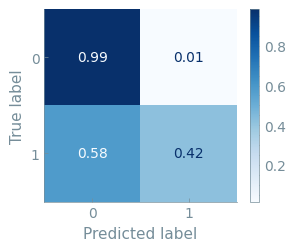

In [46]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_viscosity_confusionMatrix_78_28_size80_RF.pdf', bbox_inches='tight')